# Semana 2: Reproducción del baseline

## 1. Preprocesamiento de señales (filtrado, detección de picos R)

In [2]:
import subprocess
import sys
# #Comentar/Descomentar instalacion una vez realizada
librerias = [
    "pandas", "numpy", "seaborn", "matplotlib", "scikit-learn", "scipy"]
# Verificar e instalar las librerías faltantes
for lib in librerias:
    try:
        __import__(lib)
    except ImportError:
        print(f"Instalando {lib}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", lib])
# ###Comentar/Descomentar hasta acá###

Instalando scikit-learn...


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import ttest_ind, mannwhitneyu

sns.set_style("whitegrid")

In [4]:
from pathlib import Path

root = Path.cwd().parent

data_dir = root / 'data' / 'ecg_rr_features_curado.csv'

df = pd.read_csv(data_dir)

df.head()

,mean_rr,std_rr,skew_rr,kurt_rr,label
0,849.671415,37.965868,0.404165,3.097078,Normal
1,786.173570,87.045564,0.462868,3.968645,AFib
2,864.768854,49.730056,0.278733,2.297947,Normal
3,952.302986,28.845781,0.260759,2.672338,AFib
4,776.584663,66.450898,0.662505,2.607892,AFib


## 2. Extracción de características (HRV, estadísticas)

In [5]:
print ('Dimensiones:', df.shape, '\n\n')
print ('Tipos de datos: \n',df.dtypes, '\n\n')

print ('Valores nulos: \n',df.isnull().sum(), '\n\n')

print ('Valores únicos: \n',df.nunique(), '\n\n')

print ('Valores estadísticos: \n',df.describe())

Dimensiones: (30, 5) 


Tipos de datos: 
 mean_rr    float64
std_rr     float64
skew_rr    float64
kurt_rr    float64
label       object
dtype: object 


Valores nulos: 
 mean_rr    0
std_rr     0
skew_rr    0
kurt_rr    0
label      0
dtype: int64 


Valores únicos: 
 mean_rr    30
std_rr     30
skew_rr    30
kurt_rr    30
label       2
dtype: int64 


Valores estadísticos: 
           mean_rr     std_rr    skew_rr    kurt_rr
count   30.000000  30.000000  30.000000  30.000000
mean   781.185310  47.576751   0.502577   2.979748
std     90.000643  18.622044   0.198397   0.908822
min    608.671976  10.806598  -0.023949   1.081229
25%    740.894910  35.817727   0.397172   2.620240
50%    776.585483  48.708545   0.505122   2.969387
75%    836.033535  60.893236   0.647542   3.287354
max    957.921282  87.045564   0.812929   5.463242


Distribucion de clases 

label
Normal    18
AFib      12
Name: count, dtype: int64 



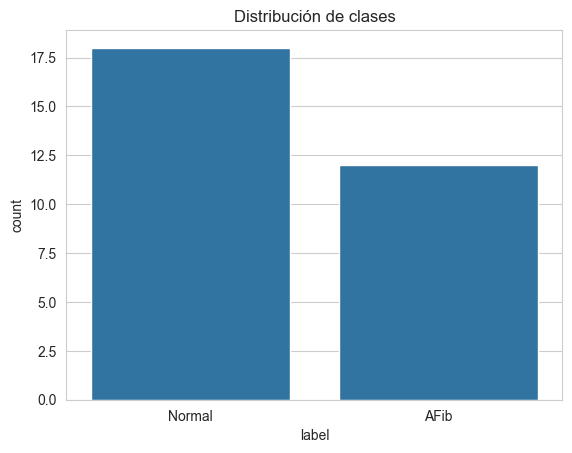

In [6]:
print ('Distribucion de clases \n')

print(df['label'].value_counts(), '\n')

sns.countplot(x = 'label', data = df)

plt.title('Distribución de clases')
plt.show()

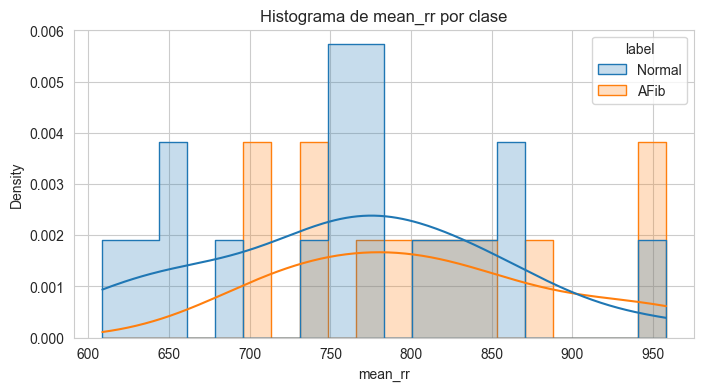

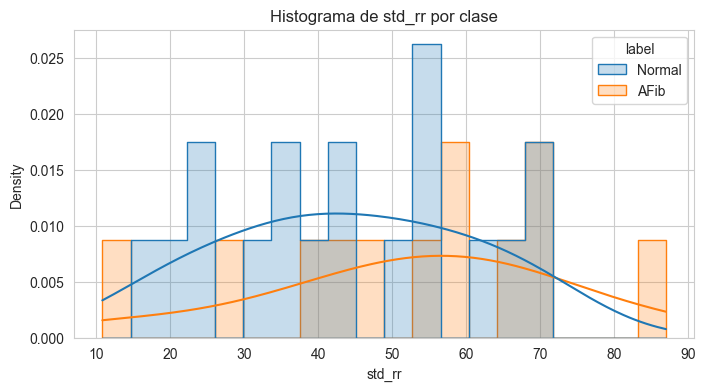

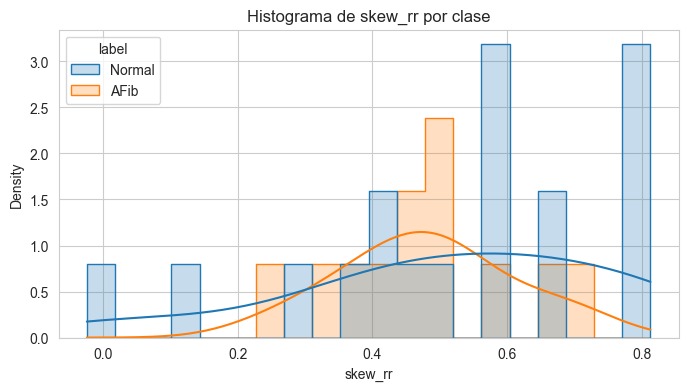

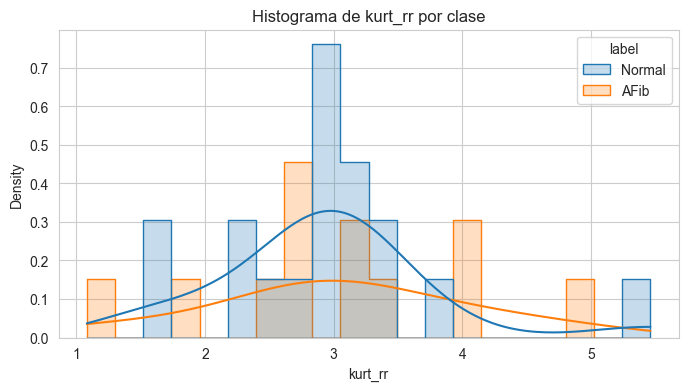

In [7]:
features = ['mean_rr', 'std_rr', 'skew_rr', 'kurt_rr']


#Histogramas
for col in features:
    plt.figure(figsize=(8,4))
    sns.histplot(data=df, x=col, hue='label', bins=20, kde=True, stat='density', element='step')
    plt.title(f'Histograma de {col} por clase')
    plt.show()

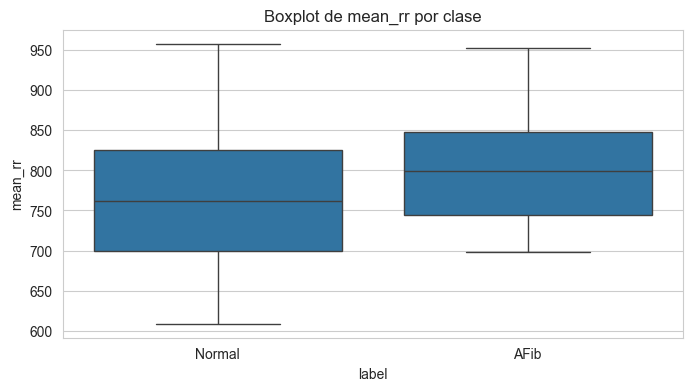

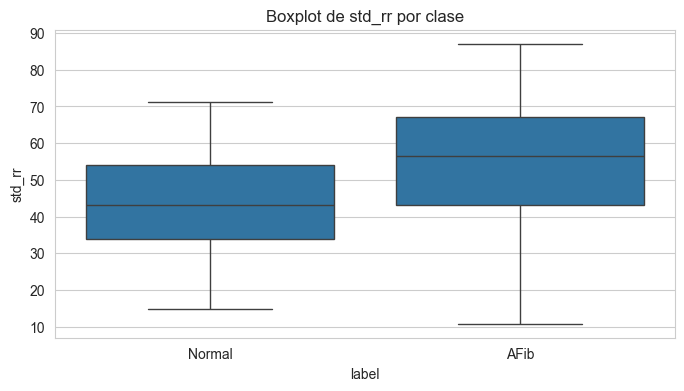

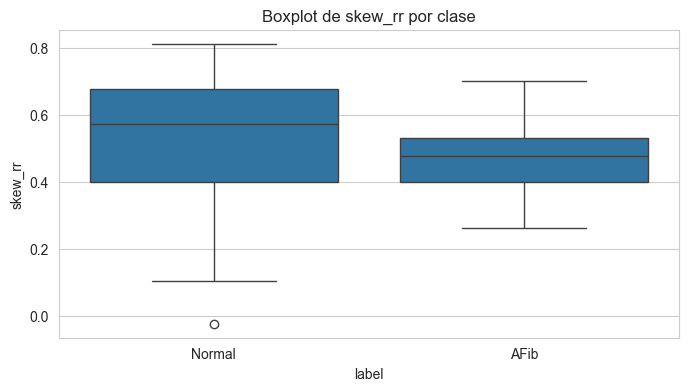

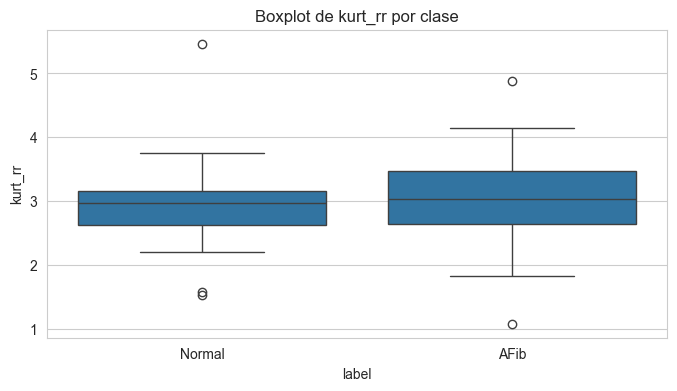

In [8]:
#Boxplot

for col in features:
    plt.figure(figsize=(8,4))
    sns.boxplot(data=df, x='label', y=col)
    plt.title(f'Boxplot de {col} por clase')
    plt.show()

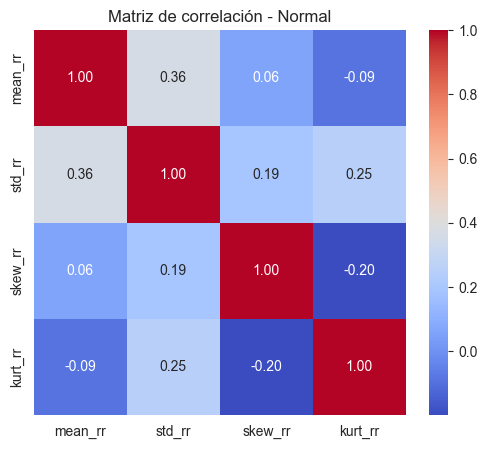

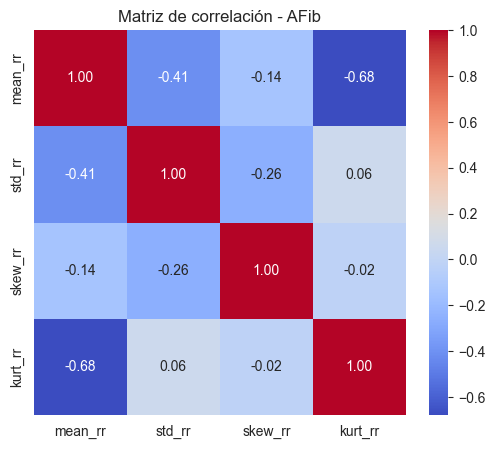

In [9]:
#Matriz de correlacion

corr = df[df['label'] == 'Normal'][features].corr()

plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de correlación - Normal')
plt.show()

corr_afib = df[df['label'] == 'AFib'][features].corr()

plt.figure(figsize=(6,5))
sns.heatmap(corr_afib, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de correlación - AFib')
plt.show()

In [10]:
#Pruebas estadísticas (t-test y Mann-Whitney)

resultados = []

for col in features:
  grupo1 = df[df['label']=='Normal'][col]
  grupo2 = df[df['label']=='AFib'][col]

  # Prueba t-test
  tstat, tpval = ttest_ind(grupo1, grupo2, equal_var=False)

  ustat, upval = mannwhitneyu(grupo1, grupo2, alternative='two-sided')

  resultados.append({
      'Variable': col,
      'T-statistic': tstat,
      'P-valor (t-test)': tpval,
      'U-statistic': ustat,
      'P-valor (Mann-Whitney)': upval
  })

  resultados_df = pd.DataFrame(resultados)

print(resultados_df)

  Variable  T-statistic  P-valor (t-test)  U-statistic  P-valor (Mann-Whitney)
0  mean_rr    -1.414657          0.169451         82.0                0.280364
1   std_rr    -1.243782          0.227456         76.0                0.182367
2  skew_rr     0.544559          0.590530        130.0                0.362734
3  kurt_rr    -0.279529          0.782608         99.0                0.718972


## 3. Entrenamiento del modelo baseline (Random Forest)

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [38]:
X = df.drop('label', axis=1)
Y = df['label']

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, 
    test_size=0.3, 
    random_state=42,
    stratify=Y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Datos de entrenamiento y prueba preparados.")
print(f"Dimensiones de X_train: {X_train.shape}, Y_train: {Y_train.shape}")
print(f"Dimensiones de X_test: {X_test.shape}, Y_test: {Y_test.shape}")

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X.columns)

Datos de entrenamiento y prueba preparados.
Dimensiones de X_train: (21, 4), Y_train: (21,)
Dimensiones de X_test: (9, 4), Y_test: (9,)


In [44]:
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay)
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neural_network import MLPClassifier


In [63]:
model = SVC(kernel='rbf', probability=True,random_state=42)
model.fit(X_train_scaled, Y_train)

model_train_pred = model.predict(X_train_scaled)
model_test_pred = model.predict(X_test_scaled)

print(f"Vectores de soportes: {model.n_support_}")
print("número de muestras de entrenamiento:", len(X_train_scaled) )

Vectores de soportes: [ 8 11]
número de muestras de entrenamiento: 21


## 4. Evaluación simple (train/test o validación cruzada)

Accuracy: 0.7619
Precision: 0.7585
Recall: 0.7619
F1 Score: 0.7584


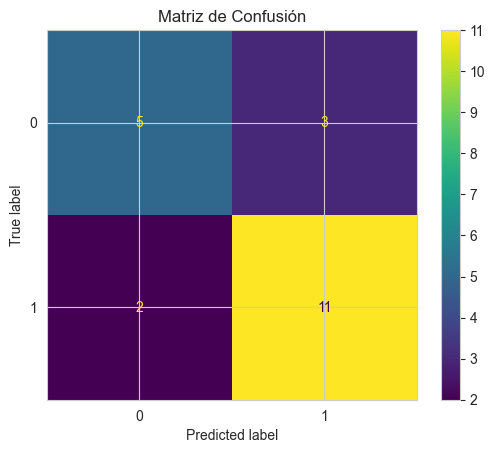

Accuracy: 0.5556
Precision: 0.7531
Recall: 0.5556
F1 Score: 0.3968


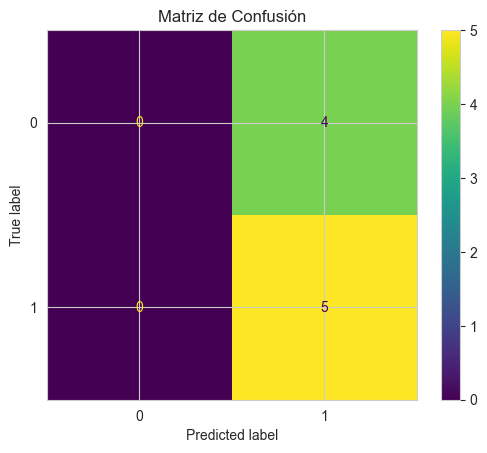

In [64]:
def metricas(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='weighted', zero_division=1)
    rec = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1 Score: {f1:.4f}")

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title('Matriz de Confusión')
    plt.show()

metricas(Y_train, model_train_pred)
metricas(Y_test, model_test_pred)

Se considera que el modelo SVM logró un desempeño aceptable en el conjunto de entrenamiento, pero mostró una caída importante en las métricas al evaluarse en el conjunto de prueba, especialmente en accuracy y F1-score. Esto sugiere que el modelo está sobreajustado y no generaliza bien a nuevos datos. Para mejorar los resultados, sería recomendable ajustar los hiperparámetros, probar otros algoritmos o incorporar más características relevantes. 